# Multi-Class Prediction of Obesity Risk - IART

The notebook is structured to guide users through a machine learning pipeline for analyzing and predicting obesity levels based on a dataset. It includes sections for data preprocessing, feature engineering, model training, evaluation, and visualization. Here's a breakdown of its purpose:

1. **Main Imports**: Essential libraries like pandas, matplotlib, seaborn, and scikit-learn are imported for data manipulation, visualization, and machine learning.

2. **Data Preprocessing**: The dataset is loaded, and unnecessary columns (like IDs) are removed. Labels for obesity categories are defined, and categorical variables are encoded.

3. **Feature Engineering**: New features like BMI are calculated, and numerical and categorical columns are identified for further processing.

4. **Data Splitting and Scaling**: The dataset is split into training and testing sets, and features are scaled for better model performance.

5. **Model Implementations**:
   - **Decision Trees**: Models are trained with and without feature selection.
   - **K-Nearest Neighbors (KNN)**: Optimal hyperparameters are explored, and models are trained with and without feature selection.
   - **Support Vector Machines (SVM)**: Models are trained with and without feature selection.
   - **Neural Networks**: A multi-layer perceptron is implemented for classification.
   - **Ensemble Methods**: A voting classifier combines multiple models for improved accuracy.

6. **Evaluation and Metrics**: Metrics like accuracy, precision, recall, and F1-score are calculated. Confusion matrices, ROC curves, and learning curves are plotted for model comparison. Validation curves and feature usage are analyzed to assess overfitting and feature importance.

7. **Visualization**: Various plots are generated to understand data distributions, feature correlations, and model performance.

## Main Imports

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Data Preprocessing

The **Data Preprocessing** section in the notebook involves preparing the dataset for analysis and machine learning. First, the training and testing datasets are loaded into pandas Dataframes and if, necessary, deleting unnecessary colummns. 

In [84]:
df_train  = pd.read_csv("data/train.csv")
df_sample = pd.read_csv("data/sample_submission.csv")
df_test   = pd.read_csv("data/train.csv")

labels = ['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III' , 'Overweight_Level_I', 'Overweight_Level_II']

# drop id (not useful)
df_train.drop('id',axis=1,inplace=True)
df_test.drop('id',axis=1,inplace=True)

## Response Factory

The **Response Factory** section defines a `Response` class that encapsulates the results of a machine learning model's predictions. It is designed to store and provide access to key outputs of a model, such as predictions, features used, prediction probabilities, and execution time.

1. **The `Response` class is initialized with the following parameters**:
     - `predictions`: The predicted labels from the model.
     - `features`: The features used by the model (if applicable).
     - `predict_proba`: The probabilities of predictions (for models that support it).
     - `start_time`: The time when the model execution started.

2. **Attributes**:
   - `self.predictions`: Stores the predicted labels.
   - `self.features`: Stores the features used by the model.
   - `self.predict_proba`: Stores the prediction probabilities.
   - `self.execution_time`: Calculates and stores the total execution time by subtracting `start_time` from the current time.

In [85]:
import time

class Response:
  def __init__(self, predictions, features, predict_proba, start_time):
    self.predictions = predictions
    self.features = features
    self.predict_proba = predict_proba
    self.execution_time = time.time() - start_time
    
  def get_predictions(self): return self.predictions
  
  def get_features(self): return self.features
  
  def get_time(self): return self.execution_time
  
  def get_predict_proba(self): return self.predict_proba    

## Additional Features

The **Additional Features** section focuses on creating new features from the existing dataset to enhance the predictive power of the machine learning models. A new feature, `BMI` (Body Mass Index), is calculated using the formula: **BMI = Weight/Height ^ 2**

- The dataset's columns are categorized into numerical and categorical types:
   - `numerical_cols`: Columns with numeric data types (`int64` or `float64`).
   - `categorical_cols`: Columns with object data types (e.g., strings or categories).
- The number of numerical and categorical columns is calculated.
- These counts are divided by 4 to determine the number of rows needed for visualizing histograms of these columns.

In [86]:
df_train['BMI'] = (df_train['Weight'] / df_train['Height']**2)

In [87]:
numerical_cols   = df_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = df_train.select_dtypes(include=[object]).columns.tolist()

num_numerical_cols = len(numerical_cols)
num_numerical_rows = num_numerical_cols // 4

num_categorical_cols = len(categorical_cols)
num_categorical_rows = num_categorical_cols // 4

## Data Spliting and Processing

The **Data Splitting and Processing** section prepares the dataset for training and testing machine learning models. Here's what happens:

- The target variable (`NObeyesdad`) is separated from the features.
- Categorical columns (excluding the target variable) are one-hot encoded using `pd.get_dummies`. This converts categorical data into numerical format suitable for machine learning models.
- The dataset is split into training and testing sets using an 80-20 split. This ensures that the model is trained on one portion of the data and tested on another to evaluate its performance.
- The target variable in the test set (`y_test`) is binarized into a one-hot encoded format. This is useful for multi-class classification tasks.
- The features in both the training and testing sets are scaled using `StandardScaler`. This standardizes the data to have a mean of 0 and a standard deviation of 1, which helps improve the performance of many machine learning algorithms.

This section ensures that the data is properly formatted, split, and scaled for effective model training and evaluation.

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize

y = df_train['NObeyesdad']
x = df_train.copy().drop(columns=['NObeyesdad'])

categoricals_cols_no_result = [col for col in categorical_cols if col != "NObeyesdad"]
x = pd.get_dummies(x, columns=categoricals_cols_no_result, drop_first=True)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20)

y_test_bin = label_binarize(y_test, classes=labels)
n_classes = y_test_bin.shape[1]

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Duplicate and NA Count

The **Duplicate and NA Count** section checks the dataset for missing values (NAs) and duplicate rows. Here's what happens:

- The total number of missing values in the dataset is calculated using `df_train.isna().sum().sum()`.
   - This ensures that the dataset does not have any missing entries that could affect model training or evaluation.
- The total number of duplicate rows in the dataset is calculated using `df_train.duplicated().sum()`.
   - Duplicate rows can introduce bias in the model, so identifying and handling them is crucial.
- By looking at the output, it's clear that there are no entries with NA values or duplicate rows. Therefore, no further processing is necessary.

In [89]:
# number of na
mv = df_train.isna().sum().sum()

# number of duplicates
dv = df_train.duplicated().sum()

# there are no NAs or Duplicates in the test dataset
print(mv)
print(dv)

0
0


## Features Distribution

The **Features Distribution** section provides an overview of the dataset's numerical and categorical features by visualizing their distributions. Here's what happens:

- The `describe()` method is used to display summary statistics for numerical and categorical columns in the dataset. This includes metrics like mean, standard deviation, minimum, maximum, and percentiles for numerical features, and counts and unique values for categorical features.
- Histograms are plotted for each numerical column to visualize their distributions. This helps identify patterns, outliers, and the spread of data.
- Histograms are also plotted for each categorical column to show the frequency of each category. This helps understand the distribution of categorical data.


In [90]:
display(df_train.describe(include=[np.number]).T, df_train.describe(include=[object]).T)

,count,mean,std,min,25%,50%,75%,max
Age,20758.0,23.841804,5.688072,14.000000,20.000000,22.815416,26.000000,61.000000
Height,20758.0,1.700245,0.087312,1.450000,1.631856,1.700000,1.762887,1.975663
Weight,20758.0,87.887768,26.379443,39.000000,66.000000,84.064875,111.600553,165.057269
FCVC,20758.0,2.445908,0.533218,1.000000,2.000000,2.393837,3.000000,3.000000
NCP,20758.0,2.761332,0.705375,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,20758.0,2.029418,0.608467,1.000000,1.792022,2.000000,2.549617,3.000000
FAF,20758.0,0.981747,0.838302,0.000000,0.008013,1.000000,1.587406,3.000000
TUE,20758.0,0.616756,0.602113,0.000000,0.000000,0.573887,1.000000,2.000000
BMI,20758.0,30.241842,8.333932,12.868541,24.088223,29.384757,37.011168,54.997991


,count,unique,top,freq
Gender,20758,2,Female,10422
family_history_with_overweight,20758,2,yes,17014
FAVC,20758,2,yes,18982
CAEC,20758,4,Sometimes,17529
SMOKE,20758,2,no,20513
SCC,20758,2,no,20071
CALC,20758,3,Sometimes,15066
MTRANS,20758,5,Public_Transportation,16687
NObeyesdad,20758,7,Obesity_Type_III,4046


### **1. Numerical Features**
- **Key Observations**:
  - The numerical features include `Age`, `Height`, `Weight`, `FCVC`, `NCP`, `CH2O`, `FAF`, `TUE`, and `BMI`.
  - The `BMI` feature was calculated as part of feature engineering (`BMI = Weight / Height^2`).

- **Descriptive Statistics**:
  - **Age**: The dataset includes individuals aged 14 to 61, with a mean age of ~23.8 years. This indicates a younger population.
  - **Height**: Heights range from 1.45m to 1.98m, with a mean of ~1.7m.
  - **Weight**: Weights range from 39kg to 165kg, with a mean of ~87.9kg. The wide range suggests significant variability in body weight.
  - **BMI**: BMI values range from ~12.87 to ~55, with a mean of ~30.24. This indicates that the dataset includes individuals across various weight categories, including underweight, normal weight, overweight, and obese.

- **Potential Issues**:
  - **Outliers**: Features like `Weight` and `BMI` may have outliers, as indicated by their wide ranges. These outliers could skew the model's performance.
  - **Skewed Distributions**: Features like `FAF` (Physical Activity Frequency) and `TUE` (Time Using Technology) have low means and standard deviations, suggesting that most individuals have low values for these features.

<!-- 
- **Potential Issues**:
  - **Imbalanced Classes**: Some categorical features, like `SMOKE` and `SCC`, are highly imbalanced, which could affect model performance.
  - **Redundant Features**: Features like `FAVC` and `CAEC` may be correlated, as both relate to eating habits.

### **Recommendations**
1. **Handle Outliers**:
   - Apply techniques like clipping or log transformation to handle outliers in `Weight` and `BMI`.

2. **Balance Classes**:
   - Use techniques like oversampling, undersampling, or class weighting to address imbalances in categorical features and the target variable.

3. **Feature Engineering**:
   - Combine or transform features like `FAVC` and `CAEC` to reduce redundancy and improve model interpretability.

4. **Scaling**:
   - Standardize numerical features to ensure they are on the same scale, as done in the preprocessing step. 
-->


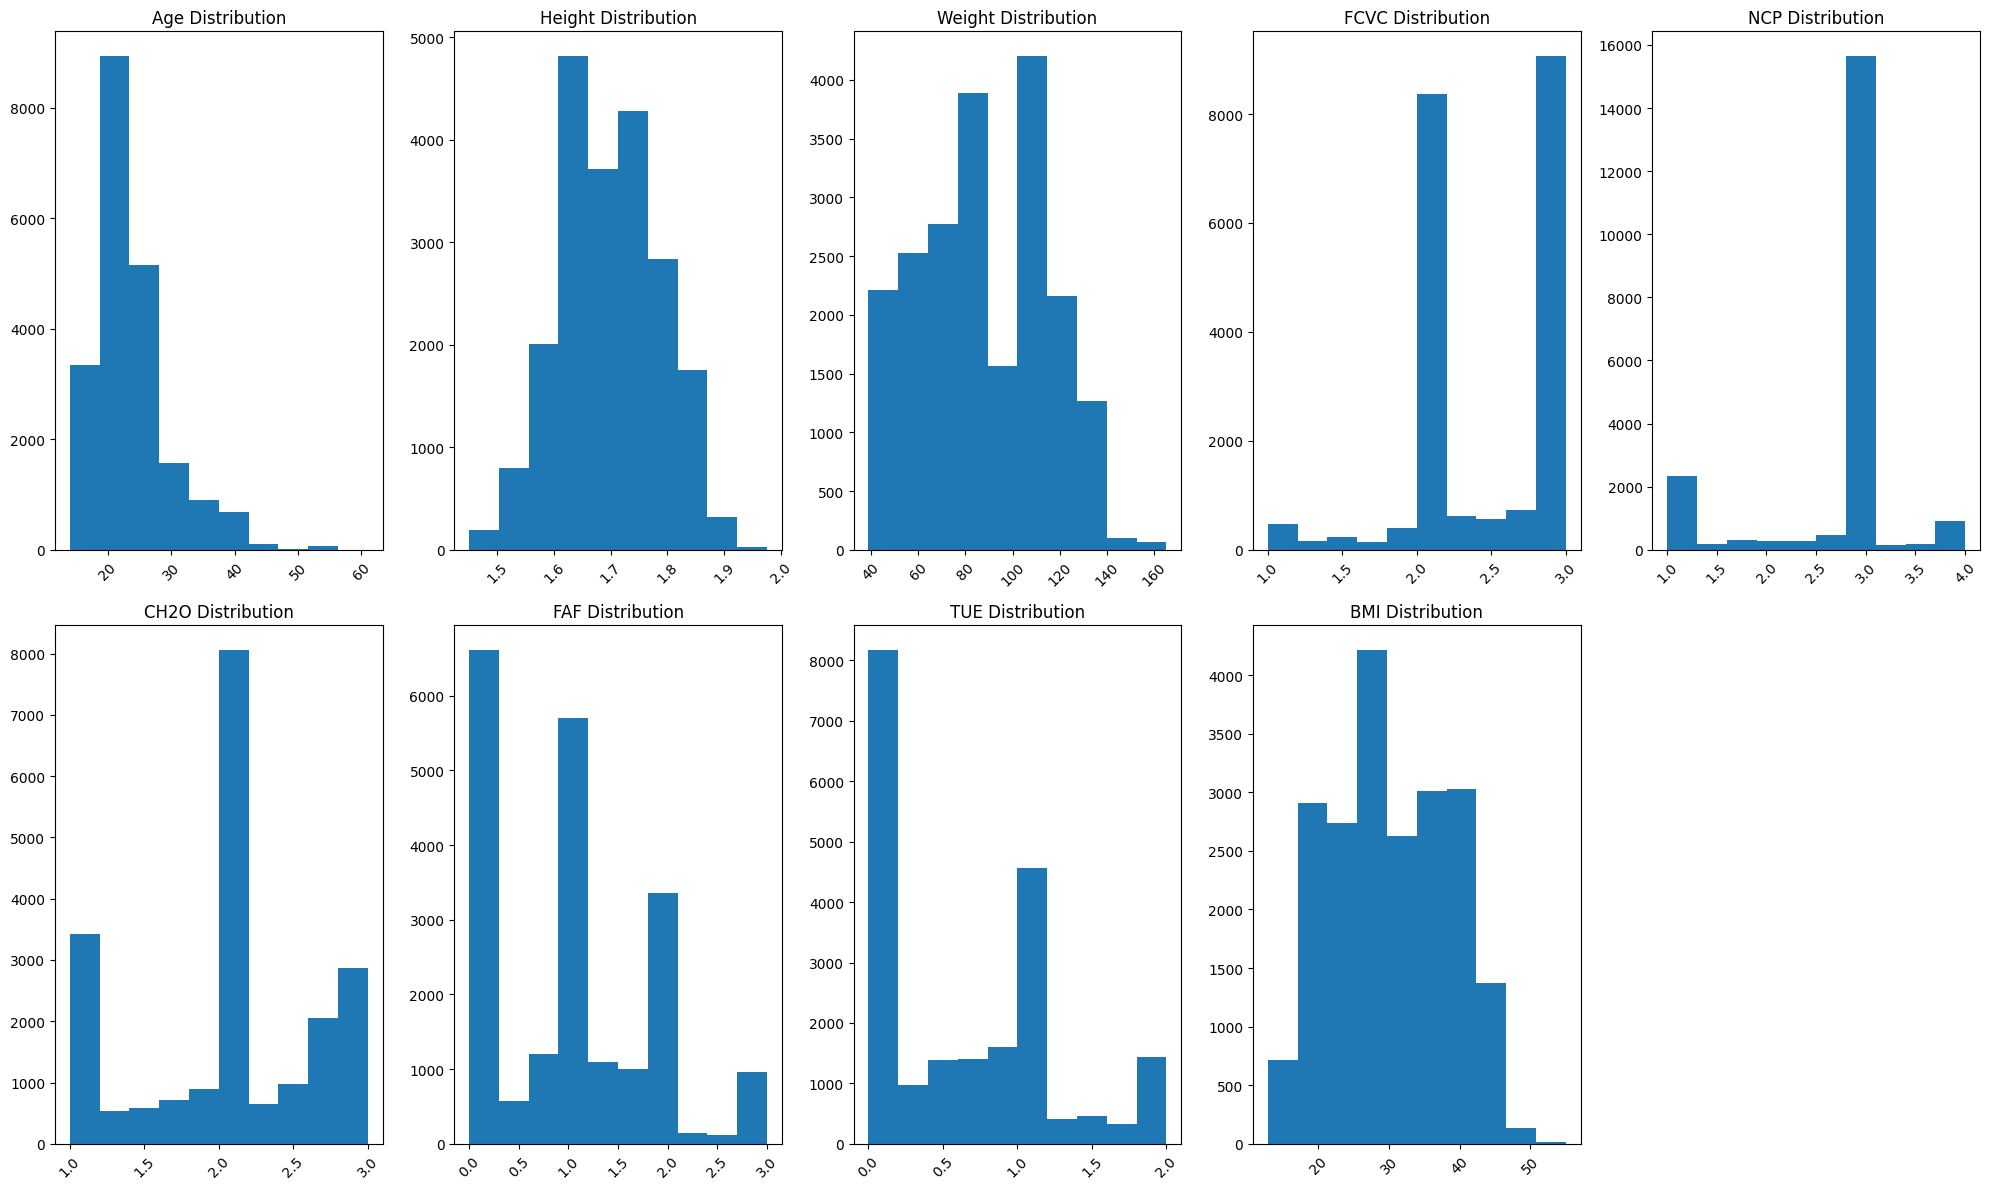

In [91]:
# numerical cols histogram
plt.figure(figsize=(20,6 * num_numerical_rows))
for i ,col in enumerate(numerical_cols,1):
    plt.subplot(num_numerical_rows, 5, i)
    plt.hist(df_train[col])
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 


### **2. Categorical Features**
- **Key Observations**:
  - The categorical features include `Gender`, `family_history_with_overweight`, `FAVC`, `CAEC`, `SMOKE`, `SCC`, `CALC`, `MTRANS`, and `NObeyesdad`.
  - The target variable, `NObeyesdad`, has 7 unique classes, with `Obesity_Type_III` being the most frequent.

- **Descriptive Statistics**:
  - **Gender**: The dataset is balanced, with slightly more females (10,422) than males.
  - **Family History**: A majority (17,014) have a family history of being overweight, which could be a strong predictor of obesity.
  - **Eating Habits**:
    - `FAVC` (Frequent Consumption of High-Calorie Food): Most individuals (18,982) consume high-calorie food frequently.
    - `CAEC` (Consumption of Food Between Meals): The most common response is "Sometimes" (17,529).
  - **Lifestyle**:
    - `SMOKE`: Most individuals (20,513) do not smoke.
    - `MTRANS` (Mode of Transportation): Public transportation is the most common mode (16,687).

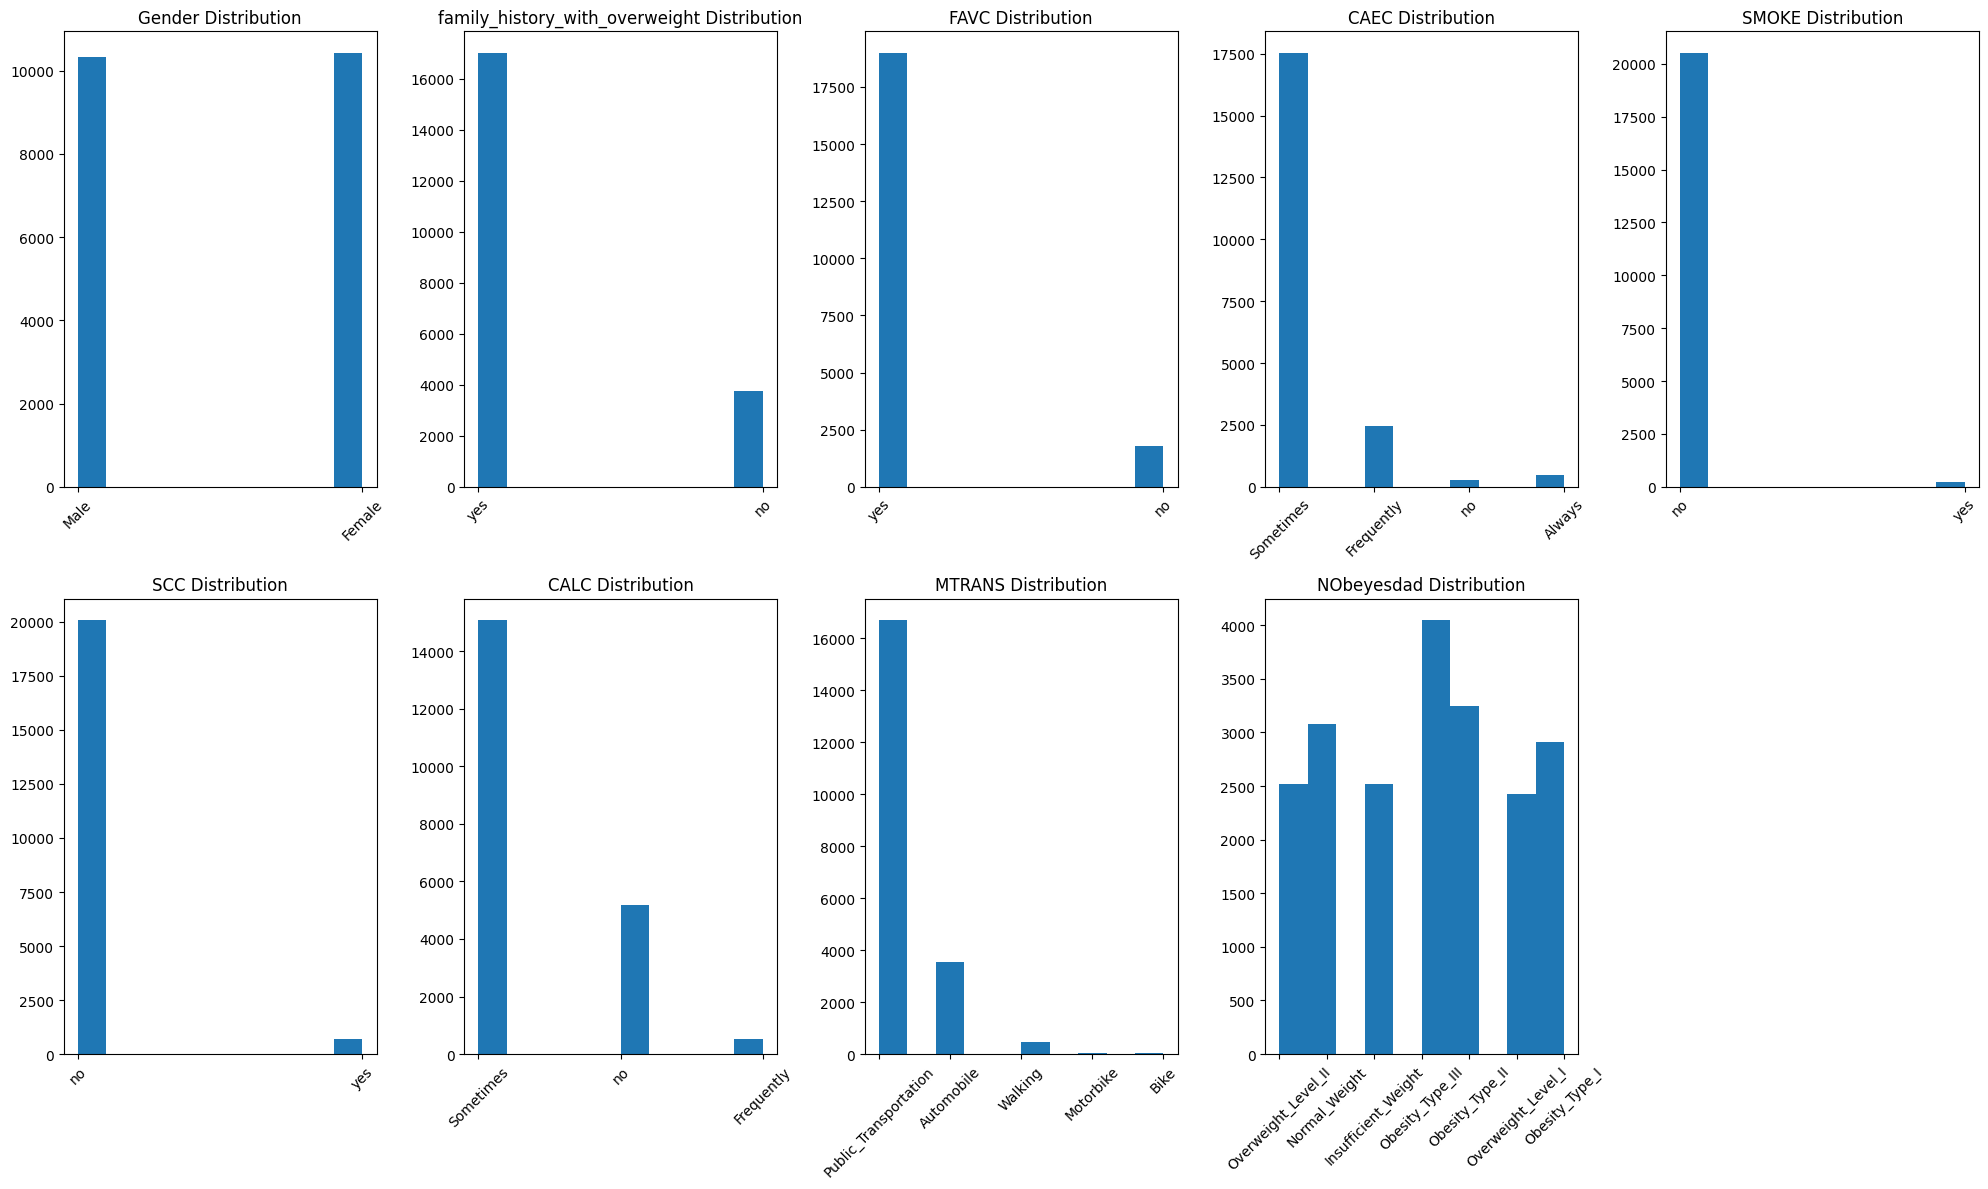

In [92]:
# categorical cols histogram
plt.figure(figsize=(20,6 * num_categorical_rows))
for i ,col in enumerate(categorical_cols,1):
    plt.subplot(num_categorical_rows, 5, i)
    plt.hist(df_train[col])
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 


## Feature Correlation

The **Feature Correlation** section analyzes the relationships between numerical features in the dataset. Here's what happens:

- A correlation matrix is computed for the numerical columns in the dataset using the `.corr()` method. This matrix shows the pairwise correlation coefficients between features, which range from -1 to 1:
  - A value close to 1 indicates a strong positive correlation.
  - A value close to -1 indicates a strong negative correlation.
  - A value near 0 indicates no correlation.

- This analysis helps identify highly correlated features, which can:
  - Indicate redundancy in the dataset (e.g., features that provide similar information).
  - Highlight relationships that may be important for predictive modeling.

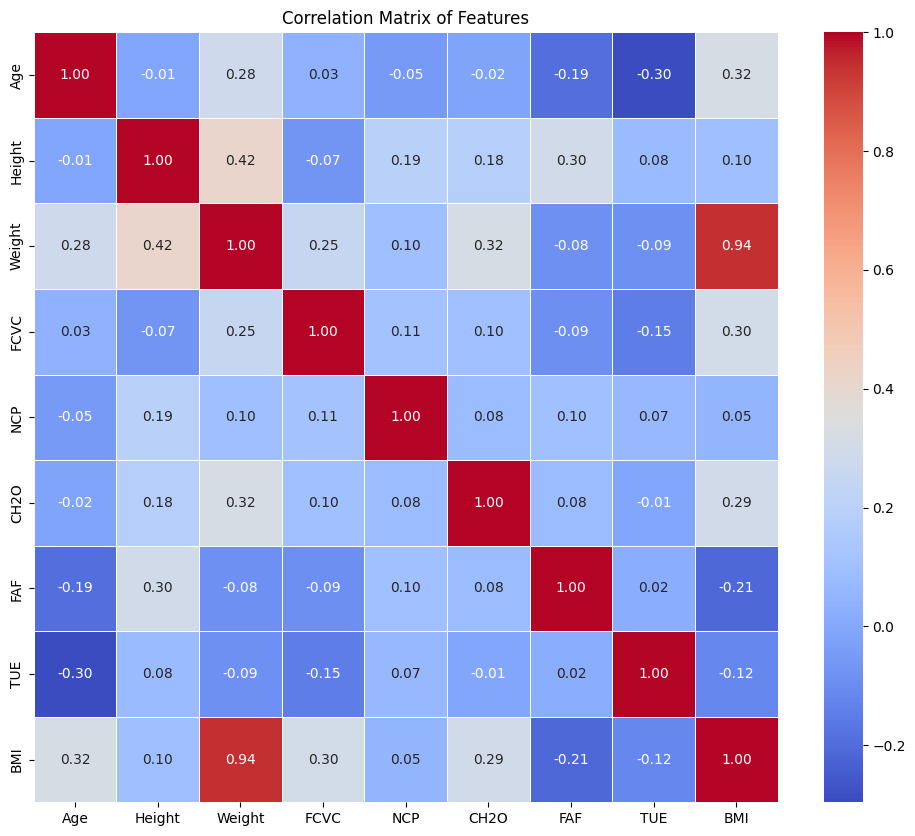

In [93]:
def corr(data):
    plt.figure(figsize=(12,10))
    sns.heatmap(data, annot=True, cmap='coolwarm', fmt='.2f', linewidths= 0.5)
    plt.title('Correlation Matrix of Features')
corr(df_train[numerical_cols].corr())

## Decision Tree

The **Decision Tree** section focuses on implementing and evaluating decision tree models for classification. It includes two approaches: one without feature selection and another with feature selection. Here's a breakdown:

### Without Feature Selection (FS)
- A `DecisionTreeClassifier` is initialized with a `ccp_alpha` parameter to control complexity and prevent overfitting.
- As there is no Feature Selection, all of the features in the dataset are used.
- The model is trained on the scaled training data (`x_train_scaled` and `y_train`).
- Predictions and prediction probabilities are generated for the test data (`x_test_scaled`).

In [94]:
from sklearn.tree import DecisionTreeClassifier
import time

def decision_tree_wfs() -> Response:
  start = time.time()

  model = DecisionTreeClassifier(ccp_alpha=0.01)
  predictions = model.fit(x_train_scaled, y_train).predict(x_test_scaled)
  predicted_proba = model.predict_proba(x_test_scaled)

  return Response(predictions, [], predicted_proba, start)


### With Feature Selection (FS)
- RFE is used to iteratively select the most important features for the decision tree model.
- The number of features to select is varied in a loop to find the optimal subset.

In [95]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import time

def decision_tree_fs() -> Response:
  start = time.time()
  
  clf = DecisionTreeClassifier(ccp_alpha=0.01)
  
  max_acc = 0
  max_features = x.shape[1]
  best_features_names = None
  best_predictions = None
  best_proba = None

  for i in range(1,max_features):
    rfe = RFE(estimator=clf, n_features_to_select=i).fit(x_train_scaled, y_train)

    selected_features = x_train.columns[rfe.support_]

    x_train_rfe = rfe.transform(x_train_scaled)
    x_test_rfe = rfe.transform(x_test_scaled)

    clf.fit(x_train_rfe, y_train)
    predictions = clf.predict(x_test_rfe)
    predicted_proba = clf.predict_proba(x_test_rfe)

    acc = accuracy_score(y_test, predictions)
    
    if(acc > max_acc): # From 3 features beyond the accuracy does not change
      max_acc = acc
      best_features_names = selected_features
      best_predictions = predictions
      best_proba = predicted_proba
    
  return Response(best_predictions, best_features_names, best_proba, start)

### Purpose
- The section demonstrates how decision trees can be used with and without feature selection to improve model performance.
- It highlights the importance of feature selection in reducing overfitting and improving interpretability.

## K-Nearest-Neighbours

The **K-Nearest Neighbors (KNN)** section focuses on implementing and evaluating KNN models for classification. It includes two approaches: one without feature selection and another with feature selection.

### Finding Optimal K
- The optimal value of `k` (number of neighbors) is determined by running the KNN model with different values of `k`.
- For each value of `k`, the model is trained, and its accuracy is evaluated on the test set.
- The results are sorted to identify the best-performing `k`.
- According to the calculations, **the best value of K is 8**.

In [96]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsClassifier
# from collections import defaultdict, Counter


# number_of_runs = 20
# number_of_neighbors = 25

# top_k_counts = Counter()
# k_accuracy_map = defaultdict(list)

# for run in range(1, number_of_runs + 1):
#     k_accuracies = []

#     for k in range(1, number_of_neighbors + 1):
#         knn = KNeighborsClassifier(n_neighbors=k)
#         knn.fit(x_train_scaled, y_train)
#         preds = knn.predict(x_test_scaled)
#         acc = accuracy_score(y_test, preds)
#         k_accuracies.append((k, acc))

#     k_accuracies.sort(key=lambda tup: tup[1], reverse=True)
    
#     for i, (k, acc) in enumerate(k_accuracies):
#         k_accuracy_map[k].append(acc)
#         if i == 0:
#             top_k_counts[k] += 1

#     best_k, best_acc = k_accuracies[0]

# avg_accuracies = {k: np.mean(accs) for k, accs in k_accuracy_map.items()}
# sorted_avg = sorted(avg_accuracies.items(), key=lambda x: x[1], reverse=True)

# best_avg_k, best_avg_acc = sorted_avg[0]
# print(f"\nBest k by average accuracy: k = {best_avg_k}\n")

# ks = sorted(avg_accuracies.keys())
# accs = [avg_accuracies[k] for k in ks]

# plt.figure(figsize=(10, 6))
# plt.plot(ks, accs, marker='o')
# plt.title("Average Accuracy for each k")
# plt.xlabel("k")
# plt.ylabel("Average Accuracy")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


### Without Feature Selection (FS)
- A `KNeighborsClassifier` is initialized with a specified number of neighbors (`k`).
- The number of neighbours was determined by the calculations in the previous cell (the optimal value is 8).

In [97]:
from sklearn.neighbors import KNeighborsClassifier
import time

def knn_wfs(num_neighbours) -> Response:
  start = time.time()
  
  model = KNeighborsClassifier(n_neighbors=num_neighbours)
  model.fit(x_train_scaled, y_train)
  predictions = model.predict(x_test_scaled)
  predicted_proba = model.predict_proba(x_test_scaled)
  
  return Response(predictions, [], predicted_proba, start)

### With Feature Selection (FS)
- The `SelectKBest` method is used to select the top `k` features based on their statistical significance.
- The number of features to select is varied in a loop to find the optimal subset.


In [98]:
from sklearn.feature_selection import SelectKBest, f_classif
import time

def knn_fs(neighbour_number) -> Response:
  start = time.time()
  
  max_acc = 0
  max_features = x.shape[1]
  best_features_names = None
  best_predictions = None
  best_proba = None
  
  knn = KNeighborsClassifier(n_neighbors=neighbour_number)

  for i in range(1, max_features):
    selector = SelectKBest(score_func=f_classif, k=i)
    x_train_selected = selector.fit_transform(x_train_scaled, y_train)
    x_test_selected = selector.transform(x_test_scaled)
    
    selected_features = x_train.columns[selector.get_support()]

    knn.fit(x_train_selected, y_train)

    predictions = knn.predict(x_test_selected)
    predicted_proba = knn.predict_proba(x_test_selected)
    acc = accuracy_score(y_test, predictions)

    if(acc > max_acc):
      max_acc = acc
      best_predictions = predictions
      best_features_names = selected_features
      best_proba = predicted_proba
      
  return Response(best_predictions, best_features_names, best_proba, start)

### Purpose
- This section demonstrates how KNN can be used with and without feature selection to improve model performance.
- It highlights the importance of hyperparameter tuning (`k`) and feature selection in optimizing the KNN model.

## Support Vector Machines

### Without Feature Selection (FS)
- An `SVC` (Support Vector Classifier) is initialized with the `probability=True` parameter to enable probability predictions.


In [99]:
from sklearn.svm import SVC
import time

def svc_wfs() -> Response:
  start = time.time()
  model = SVC(probability=True)
  model.fit(x_train_scaled, y_train)
  predictions = model.predict(x_test_scaled)
  predicted_proba = model.predict_proba(x_test_scaled)

  return Response(predictions, [], predicted_proba, start)

### With Feature Selection (FS)
- RFE is used to iteratively select the most important features for the SVM model.
- The number of features to select is varied in a loop to find the optimal subset.

In [100]:
from sklearn.feature_selection import RFE
import time 

def svc_fs() -> Response:
  start = time.time()
  
  print("fitting")
  svc = SVC(kernel="linear", probability=True)
  print("fitted")
  
  max_acc = 0
  best_features_names = None
  max_features = x.shape[1]
  best_predictions = None
  best_proba = None

  for i in range(1,max_features):
    print("sfs")
    sfs = RFE(
        estimator=svc,
        n_features_to_select=i, 
        step=1
    ).fit(x_train_scaled, y_train)
    
    selected_features = x_train.columns[sfs.get_support()]
    print("Selected features: " + str(selected_features))
    
    x_train_sfs = sfs.transform(x_train_scaled)
    x_test_sfs = sfs.transform(x_test_scaled)

    svc.fit(x_train_sfs, y_train)

    predictions = svc.predict(x_test_sfs)
    predicted_proba = svc.predict_proba(x_test_sfs)
    acc = accuracy_score(y_test, predictions)

    if(acc > max_acc):
      max_acc = acc
      best_predictions = predictions
      best_features_names = selected_features
      best_proba = predicted_proba
      
  return Response(best_predictions, best_features_names, best_proba, start)

### Purpose
- This section demonstrates how SVM can be used with and without feature selection to improve model performance.
- It highlights the importance of feature selection in reducing overfitting and improving interpretability.

Would you like to explore the implementation of feature selection or the evaluation metrics in more detail?

## Neural Networks

The **Neural Networks** section focuses on implementing and evaluating a neural network model for classification. Here's a breakdown:

- The model is configured with:
   - **Hidden Layers**: Three layers with sizes `(128, 64, 32)`.
   - **Activation Function**: ReLU (Rectified Linear Unit) for non-linearity.
   - **Solver**: Adam optimizer for weight optimization.
   - **Learning Rate**: Adaptive, which adjusts the learning rate based on performance.
   - **Early Stopping**: Enabled to stop training if validation performance does not improve for a specified number of iterations.
   - **Validation Fraction**: 20% of the training data is used for validation during training.
- This section demonstrates the use of a neural network for multi-class classification.
- It highlights the flexibility of neural networks in handling complex patterns in data.

In [101]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import time

def neural_networks() -> Response:
    start = time.time()
    
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    model = MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',                    
        alpha=0.0001,                      
        batch_size='auto',
        learning_rate='adaptive',         
        max_iter=1000,                     
        early_stopping=True,               
        validation_fraction=0.2,          
        n_iter_no_change=10,          
    )
    
    model.fit(x_train_scaled, y_train_encoded)
    predictions_encoded = model.predict(x_test_scaled)
    predicted_proba = model.predict_proba(x_test_scaled)
    
    predictions = label_encoder.inverse_transform(predictions_encoded)

    return Response(predictions, [], predicted_proba, start)

## Ensemble

The **Ensemble** section focuses on combining multiple machine learning models to improve overall performance. Ensemble methods leverage the strengths of individual models to make more robust and accurate predictions.

- An **ensemble** is a combination of multiple models (often called base models or estimators) that work together to produce a single prediction.
- A `VotingClassifier` is used to combine multiple models. It aggregates the predictions of the base models using a "hard" voting strategy, where the majority class is selected as the final prediction.
- Base Models:
   - The ensemble includes the following base models:
     - **Decision Tree** (`DecisionTreeClassifier`)
     - **K-Nearest Neighbors (KNN) (`KNeighborsClassifier`)
     - **Neural Network** (`MLPClassifier`)
     - **Support Vector Machine (SVM) (`SVC`)

In [102]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

clf = DecisionTreeClassifier(ccp_alpha=0.01)
knn = KNeighborsClassifier(n_neighbors=6)
mlp = MLPClassifier(
    hidden_layer_sizes=(250, 150, 100),
    activation='relu',
    solver='adam',                    
    alpha=0.0001,                      
    batch_size='auto',
    learning_rate='adaptive',         
    max_iter=1000,                     
    early_stopping=True,               
    validation_fraction=0.2,          
    n_iter_no_change=10,          
)
svc = SVC()

ensemble = VotingClassifier(estimators=[("clf", clf), ("knn", knn), ("mlp", mlp), ("svc", svc)], voting="hard")

ensemble.fit(x_train_scaled, y_train)
print(f"Accuracy of the ensemble: {round(ensemble.score(x_test_scaled, y_test)*100, 2)} %")

Accuracy of the ensemble: 87.62 %


### Purpose
- The ensemble method aims to improve the overall accuracy and robustness of predictions by combining the strengths of different models.
- It reduces the risk of overfitting and leverages the diversity of the base models to handle various patterns in the data.

## Metrics

The **Metrics** section focuses on evaluating the performance of the machine learning models using various metrics and visualizations.



### Metrics Processing
- The following metrics are calculated for each model:
   - **Accuracy**: The proportion of correctly classified instances.
   - **Precision**: The proportion of true positive predictions out of all positive predictions.
   - **Recall**: The proportion of true positives out of all actual positives.
   - **F1-Score**: The harmonic mean of precision and recall.
   - **Execution Time**: The time taken to train and evaluate the model.
   - **Features Used**: The number of features used by the model (if applicable).

- **Table Comparison**
   - The metrics for all models are compiled into a pandas DataFrame.
   - The table is printed to provide a clear comparison of the models' performance.
- **Confusion Matrices Comparison**
   - Confusion matrices are generated for each model to visualize the distribution of true positives, true negatives, false positives, and false negatives.
   - The matrices are displayed in a grid format for easy comparison.
- **Learning Curves**
   - Learning curves are plotted for each model to show how the training and testing accuracy change with the size of the training dataset.
   - This helps identify issues like underfitting or overfitting.
- **ROC Curves Comparison**
   - Receiver Operating Characteristic (ROC) curves are plotted for each model to evaluate their performance across different classification thresholds.
   - The curves are displayed for each class, showing the trade-off between true positive rate and false positive rate.
- **Validation Curves Comparison**
   - Validation curves are plotted to analyze the impact of hyperparameters (e.g., `ccp_alpha` for Decision Trees, `n_neighbors` for KNN, and `C` for SVM) on model performance.
   - These curves help in selecting optimal hyperparameter values.
- **Feature Usage**
   - A bar chart is plotted to show the number of features used by each model.
   - This helps in understanding the complexity of the models and their reliance on feature selection.
- **Overfitting Analysis**
   - The training and testing accuracies of the models are compared.
   - Models with a large gap between training and testing accuracy are flagged as overfitting.

<!-- ### Purpose
- This section provides a comprehensive evaluation of the models, helping to identify the best-performing model and areas for improvement.
- It uses a combination of metrics, visualizations, and analyses to ensure a thorough understanding of model performance. -->


### Metrics Processing

In [103]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt
import pandas as pd

def get_model_metrics(response, model_name):
    predictions = response.get_predictions()
    return {
        'Model': model_name,
        'Accuracy': round(accuracy_score(y_test, predictions) * 100, 2),
        'Precision': round(precision_score(y_test, predictions, average="macro") * 100, 2),
        'Recall': round(recall_score(y_test, predictions, average='macro') * 100, 2),
        'F1-Score': round(f1_score(y_test, predictions, average='macro') * 100, 2),
        'Time (s)': round(response.get_time(), 2),
        'Features': len(response.get_features()) if len(response.get_features()) else 'All'
    }

def run_model(model_func, model_name, *args):
    print("Running " + model_name)
    return model_func(*args)

models = {}
model_functions = [
    ('Decision Tree (No FS)', decision_tree_wfs, []),
    ('Decision Tree (FS)', decision_tree_fs, []),
    ('KNN (No FS)', knn_wfs, [8]),
    ('KNN (FS)', knn_fs, [8]),
    ('SVM (No FS)', svc_wfs, []),
    # ('SVM (FS)', svc_fs, []),
    ('Neural Network', neural_networks, [])
]

for model_name, model_func, args in model_functions:
    result = run_model(model_func, model_name, *args)
    if result is not None:
        models[model_name] = result

Running Decision Tree (No FS)
Running Decision Tree (FS)
Running KNN (No FS)
Running KNN (FS)
Running SVM (No FS)
Running Neural Network


## Feature relevance

The **Feature Relevance** section in the notebook focuses on analyzing the importance of features used by the **Decision Tree** algorithm. This analysis is specific to Decision Trees because they inherently provide a measure of feature importance based on how much each feature contributes to reducing impurity (e.g., Gini impurity or entropy) in the splits.

- The `DecisionTreeClassifier` has an attribute called `feature_importances_`, which provides a numerical value for each feature. This value represents the relative importance of the feature in making predictions.
- Features with higher importance values contribute more to the model's decision-making process.
- After training the Decision Tree model, the `feature_importances_` attribute is extracted.
- A bar chart is plotted to display the top 10 most important features. This helps in visually understanding which features the Decision Tree relies on the most.
- This analysis can guide feature engineering by highlighting features that contribute the most to the model's performance.
- Feature relevance is specific to the Decision Tree algorithm and cannot be directly applied to other models like KNN, SVM, or Neural Networks.

<Axes: >

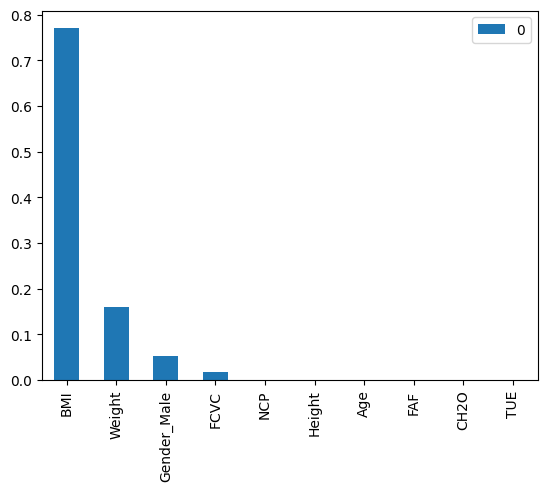

In [104]:
model = DecisionTreeClassifier(ccp_alpha=0.01)
predictions = model.fit(x_train_scaled, y_train).predict(x_test_scaled)
feature_importance = pd.DataFrame(model.feature_importances_, index = x.columns).sort_values(0, ascending=False)
feature_importance.head(10).plot(kind='bar')

## Table Comparison

The provided metrics table summarizes the performance of various machine learning algorithms with and without feature selection (FS). Here's an analysis of the data:

### **1. Decision Tree**
- **Without Feature Selection (No FS):**
  - Accuracy, Precision, Recall, and F1-Score are all **84.22%** and **82.66-82.80%**, respectively.
  - Execution time is very low (**0.12 seconds**).
  - Uses **all features**, which may lead to overfitting.

- **With Feature Selection (FS):**
  - Performance metrics remain the same as No FS (**84.22% accuracy**).
  - Execution time increases significantly to **19.34 seconds**, likely due to the feature selection process.
  - Uses only **3 features**, improving interpretability and reducing complexity.

**Observation:** Feature selection does not improve performance but reduces the number of features used, which may help with interpretability.

### **2. K-Nearest Neighbors (KNN)**
- **Without Feature Selection (No FS):**
  - Accuracy is **77.36%**, with Precision, Recall, and F1-Score around **74.72-74.83%**.
  - Execution time is low (**0.16 seconds**).
  - Uses **all features**, which may not be optimal for KNN.

- **With Feature Selection (FS):**
  - Accuracy improves significantly to **87.24%**, with Precision, Recall, and F1-Score around **85.72-85.75%**.
  - Execution time increases to **4.06 seconds** due to feature selection.
  - Uses only **5 features**, which likely improves performance by reducing noise.

**Observation:** Feature selection greatly improves KNN's performance, making it more efficient and accurate.

### **3. Support Vector Machine (SVM)**
- **Without Feature Selection (No FS):**
  - Accuracy is **87.52%**, with Precision, Recall, and F1-Score around **86.02-86.16%**.
  - Execution time is relatively high (**9.94 seconds**).
  - Uses **all features**, which may increase computational cost.

**Observation:** SVM performs well without feature selection, but feature selection could potentially reduce computational cost.

### **4. Neural Network**
- Accuracy is the highest among all models at **87.93%**, with Precision, Recall, and F1-Score around **86.46-86.63%**.
- Execution time is moderate (**1.16 seconds**).
- Uses **all features**, which is expected for neural networks due to their ability to handle complex patterns.

**Observation:** Neural networks achieve the best performance overall, balancing accuracy and execution time.

### **Key Observations**
- Neural Network (**87.93%**) slightly outperforms SVM (**87.52%**) and KNN with FS (**87.24%**).
- Feature selection significantly improves KNN's performance but has no effect on Decision Tree accuracy.
- Decision Tree (No FS) is the fastest model (**0.12 seconds**).
- Models with feature selection (Decision Tree FS, KNN FS) use fewer features, which can simplify the model and reduce overfitting.


In [105]:
if models:
    metrics = []
    for model_name, response in models.items():
        metrics.append(get_model_metrics(response, model_name))

    table = pd.DataFrame(metrics)
    print(table.to_string(index=False))

                Model  Accuracy  Precision  Recall  F1-Score  Time (s) Features
Decision Tree (No FS)     84.06      82.71   82.70     82.62      0.15      All
   Decision Tree (FS)     84.06      82.71   82.70     82.62     23.53        4
          KNN (No FS)     77.07      74.60   74.79     74.61      0.26      All
             KNN (FS)     87.36      86.04   86.18     86.08      7.03        4
          SVM (No FS)     86.75      85.38   85.47     85.38     15.88      All
       Neural Network     87.57      86.28   86.31     86.27      3.22      All


## Confusion Matrices Comparison

The confusion matrices provide a detailed breakdown of the classification performance for each model. Here's an analysis of the results:



### **1. Decision Tree (No FS)**
- **Strengths**:
  - Performs well on most classes, especially for "Obesity_Type_II" and "Obesity_Type_III," with high true positive counts.
  - Misclassifications are relatively low for most classes.
- **Weaknesses**:
  - Some confusion between "Normal_Weight" and "Overweight_Level_I."
  - Slight misclassification of "Overweight_Level_II" as "Overweight_Level_I."



### **2. Decision Tree (FS)**
- **Strengths**:
  - Similar performance to the Decision Tree (No FS), with high true positive counts for "Obesity_Type_II" and "Obesity_Type_III."
  - Reduces the number of features used, improving interpretability.
- **Weaknesses**:
  - No significant improvement in classification accuracy compared to the No FS version.
  - Misclassifications remain similar, indicating that feature selection did not enhance performance.



### **3. KNN (No FS)**
- **Strengths**:
  - Performs reasonably well for "Obesity_Type_II" and "Obesity_Type_III."
- **Weaknesses**:
  - Struggles with "Normal_Weight" and "Overweight_Level_I," showing higher misclassification rates.
  - Overall performance is lower compared to other models, with more confusion across classes.



### **4. KNN (FS)**
- **Strengths**:
  - Significant improvement in classification accuracy compared to KNN (No FS).
  - Handles "Obesity_Type_II" and "Obesity_Type_III" well, with fewer misclassifications.
  - Feature selection reduces noise, leading to better predictions.
- **Weaknesses**:
  - Some confusion remains between "Normal_Weight" and "Overweight_Level_I."



### **5. SVM (No FS)**
- **Strengths**:
  - High true positive counts for "Obesity_Type_II" and "Obesity_Type_III."
  - Performs well across most classes, with fewer misclassifications compared to KNN.
- **Weaknesses**:
  - Slight confusion between "Normal_Weight" and "Overweight_Level_I."
  - Computationally expensive due to the use of all features.



### **6. Neural Network**
- **Strengths**:
  - Best overall performance, with the highest true positive counts across most classes.
  - Handles "Obesity_Type_II" and "Obesity_Type_III" exceptionally well.
  - Minimal confusion between classes, indicating strong generalization.
- **Weaknesses**:
  - Slight misclassification of "Overweight_Level_II" as "Overweight_Level_I."
  - Computationally more intensive compared to simpler models.



### **Key Observations**
- The **Neural Network** achieves the best overall performance, with minimal confusion and high true positive counts.
- Feature selection significantly improves KNN's performance but has little effect on the Decision Tree.
- Most models struggle with distinguishing between "Normal_Weight" and "Overweight_Level_I," as well as "Overweight_Level_I" and "Overweight_Level_II."
- Simpler models like Decision Trees and KNN (No FS) show more confusion, while more complex models like SVM and Neural Networks handle class distinctions better.

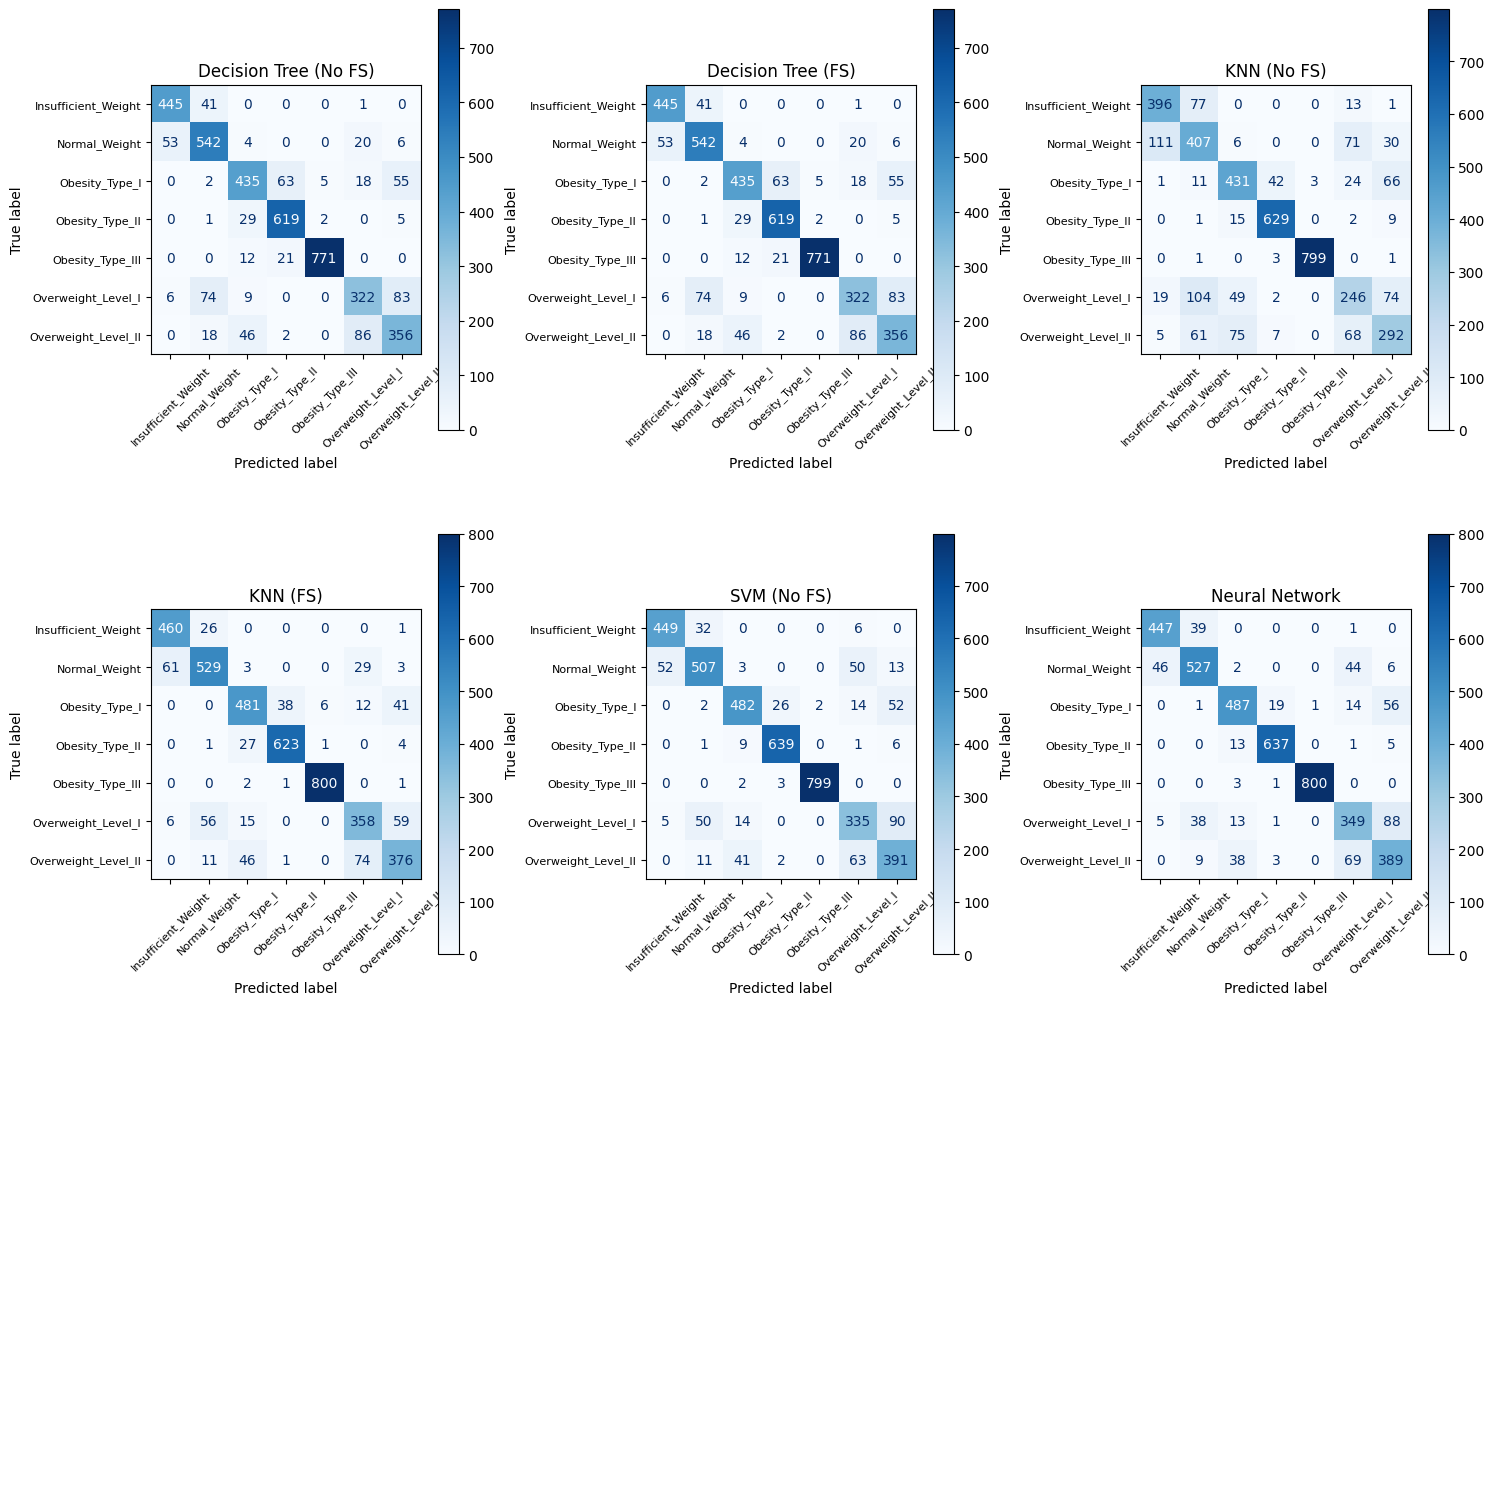

In [106]:
from sklearn.metrics import ConfusionMatrixDisplay

if models:
    cols = 3
    rows = 3
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = axes.flatten()

    for i, (model_name, response) in enumerate(models.items()):
        if i < len(axes):
            cm = confusion_matrix(y_test, response.get_predictions(), labels=labels)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
            disp.plot(ax=axes[i], cmap='Blues', values_format='d')
            axes[i].set_title(model_name, fontsize=12)
            axes[i].tick_params(axis='x', rotation=45, labelsize=8)
            axes[i].tick_params(axis='y', labelsize=8)

    for i in range(len(models), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

## Learning Curves

The learning curves provide insights into the performance of the models as the training set size increases. Here's an analysis of the results based on the provided plots:



### **1. Decision Tree**
- **Training Score**: Remains at 100%, indicating the model perfectly fits the training data.
- **Test Score**: Increases slightly with more training data but remains significantly lower than the training score.
- **Observation**: The large gap between training and test scores suggests **overfitting**. The Decision Tree memorizes the training data but struggles to generalize to unseen data.



### **2. Support Vector Classifier (SVC)**
- **Training Score**: Starts high and decreases slightly as the training set grows, stabilizing at a high level.
- **Test Score**: Gradually increases with more training data, converging closer to the training score.
- **Observation**: The small gap between training and test scores indicates **good generalization**. SVC benefits from more data and avoids overfitting.



### **3. K-Nearest Neighbors (KNN)**
- **Training Score**: Starts high but decreases as the training set grows, stabilizing at a moderate level.
- **Test Score**: Increases steadily with more training data but remains lower than the training score.
- **Observation**: The moderate gap between training and test scores suggests **underfitting**. KNN struggles to capture complex patterns, especially with all features included.



### **4. Neural Network (MLPClassifier)**
- **Training Score**: Starts high but decreases as the training set grows, stabilizing at a reasonable level.
- **Test Score**: Increases steadily with more training data, converging closer to the training score.
- **Observation**: The small gap between training and test scores indicates **good generalization**. Neural Networks handle complex patterns well and benefit from larger datasets.



### **Key Observations**
- The Decision Tree shows clear signs of overfitting, as evidenced by the perfect training score and lower test score.
- KNN shows signs of underfitting, as both training and test scores are relatively low.
- SVC and Neural Networks demonstrate the best generalization, with small gaps between training and test scores.
- All models, except the Decision Tree, benefit from more training data, as test scores improve with larger datasets.

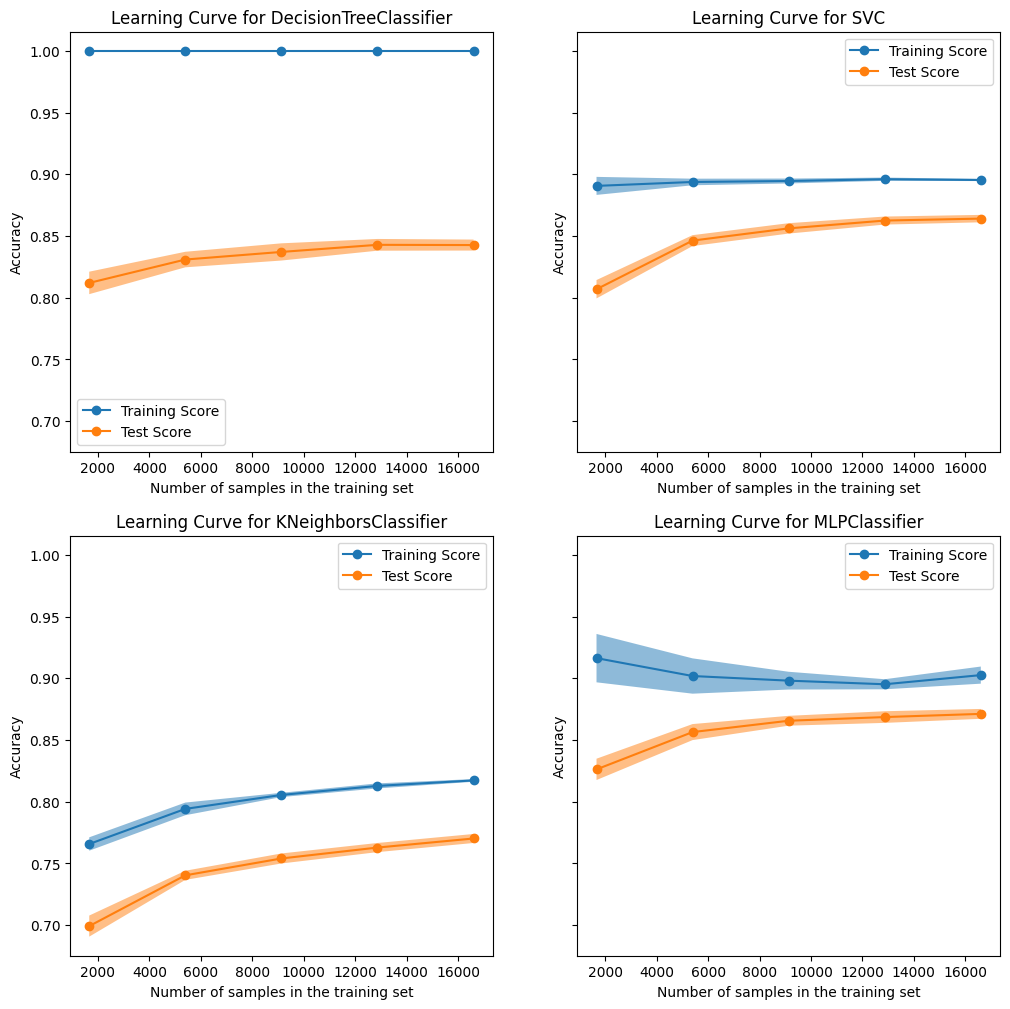

In [107]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), sharey=True)
ax = axes.flatten()

label_encoder = LabelEncoder()
scaler = StandardScaler()

new_x = scaler.fit_transform(x)
new_y = label_encoder.fit_transform(y)

common_params = {
    "X": new_x,
    "y": new_y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

clf = DecisionTreeClassifier()
svc = SVC()
knn = KNeighborsClassifier(n_neighbors=8)
nn = MLPClassifier(
    hidden_layer_sizes=(250, 150, 100),
    activation='relu',
    solver='adam',                    
    alpha=0.0001,                      
    batch_size='auto',
    learning_rate='adaptive',         
    max_iter=1000,                     
    early_stopping=True,               
    validation_fraction=0.2,          
    n_iter_no_change=10,          
)


for ax_idx, estimator in enumerate([clf, svc,knn,nn]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:4], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

## ROC Curves Comparison

The ROC curves provide insights into the classification performance of the models across different obesity categories. Here's an analysis based on the provided plots:



### **1. Decision Tree (No FS and FS)**
- **AUC Scores**: Consistently high (around 0.93–0.99) across most classes.
- **Strengths**:
  - Performs well for classes like "Insufficient_Weight," "Obesity_Type_II," and "Obesity_Type_III" with AUC values close to 0.99.
- **Weaknesses**:
  - Slightly lower AUC for "Overweight_Level_I" and "Overweight_Level_II" (around 0.93).
  - Feature selection (FS) does not significantly improve AUC, indicating that the model's performance is not heavily dependent on feature reduction.



### **2. K-Nearest Neighbors (No FS and FS)**
- **AUC Scores**:
  - Without FS: Moderate performance (AUC ~0.87–0.96).
  - With FS: Significant improvement (AUC ~0.94–0.99).
- **Strengths**:
  - Feature selection improves performance, especially for "Obesity_Type_II" and "Obesity_Type_III."
- **Weaknesses**:
  - Struggles with "Normal_Weight" and "Overweight_Level_I" without FS (AUC ~0.87–0.91).
  - Indicates sensitivity to irrelevant features, which FS mitigates.



### **3. Support Vector Machine (SVM)**
- **AUC Scores**: High across all classes (AUC ~0.96–1.00).
- **Strengths**:
  - Excellent performance for "Obesity_Type_II" and "Obesity_Type_III" (AUC ~1.00).
  - Consistently strong generalization across all classes.
- **Weaknesses**:
  - Slightly lower AUC for "Overweight_Level_I" (AUC ~0.96), indicating minor confusion in this class.



### **4. Neural Network**
- **AUC Scores**: Highest overall (AUC ~0.96–1.00).
- **Strengths**:
  - Perfect AUC (1.00) for "Obesity_Type_II" and "Obesity_Type_III."
  - Handles complex patterns effectively, achieving near-perfect performance across most classes.
- **Weaknesses**:
  - Slightly lower AUC for "Overweight_Level_I" and "Overweight_Level_II" (AUC ~0.96–0.97), similar to SVM.



### **Key Observations**
- The **Neural Network** achieves the highest AUC scores overall, closely followed by SVM.
- Feature selection significantly improves KNN's performance but has minimal impact on the Decision Tree.
- Most models struggle slightly with "Overweight_Level_I" and "Overweight_Level_II," likely due to overlapping features between these classes.
- SVM and Neural Networks demonstrate the best generalization, with consistently high AUC scores across all classes.

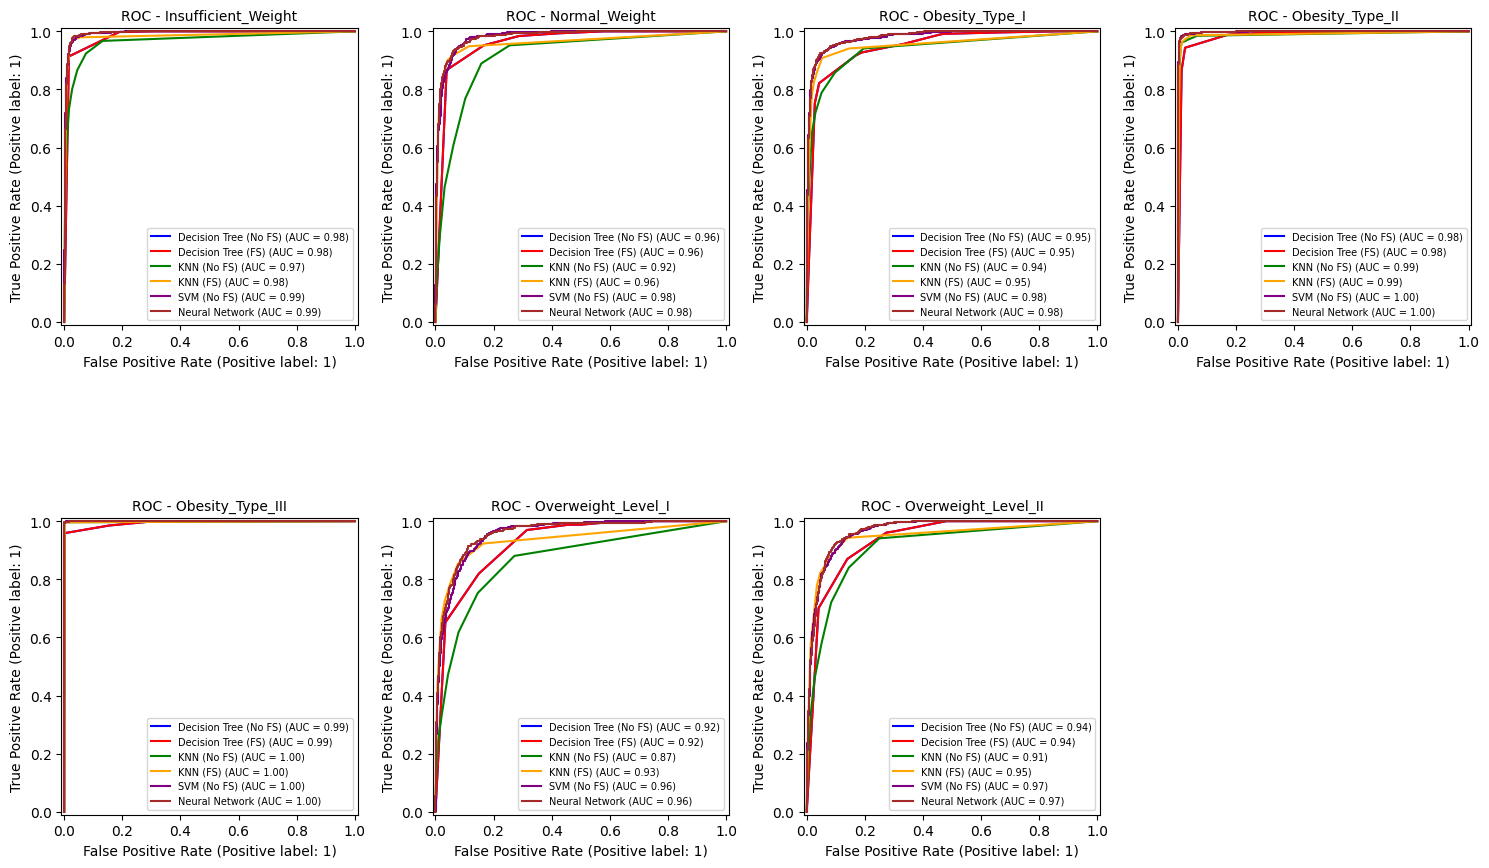

In [108]:
if models:
    plt.figure(figsize=(15, 10))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
    
    for i in range(n_classes):
        plt.subplot(2, 4, i + 1)
        
        for j, (model_name, response) in enumerate(models.items()):        
            RocCurveDisplay.from_predictions(
                y_test_bin[:, i],
                response.get_predict_proba()[:, i],
                name=model_name,
                color=colors[j % len(colors)],
                ax=plt.gca()
            )
        
        plt.title("ROC - " + labels[i], fontsize=10)
        plt.legend(fontsize=7, loc='lower right')
    
    plt.tight_layout()
    plt.show()

### Validation Curves Comparison

The validation curves provide insights into how the models' performance changes with different hyperparameter values. Here's an analysis based on the provided plots:



### **1. Decision Tree**
- **Hyperparameter**: `ccp_alpha` (complexity parameter for pruning).
- **Training Curve**:
  - Accuracy decreases as `ccp_alpha` increases, indicating that higher pruning reduces the model's ability to fit the training data.
  - At very low `ccp_alpha`, the model overfits, achieving near-perfect training accuracy.
- **Validation Curve**:
  - Accuracy initially increases slightly as `ccp_alpha` increases, suggesting that mild pruning helps reduce overfitting.
  - Beyond a certain point, validation accuracy drops sharply, indicating underfitting due to excessive pruning.
- **Optimal Range**:
  - A balance between training and validation accuracy is observed at moderate `ccp_alpha` values (e.g., around `10^-3`).



### **2. K-Nearest Neighbors (KNN)**
- **Hyperparameter**: `n_neighbors` (number of neighbors).
- **Training Curve**:
  - Accuracy decreases as `n_neighbors` increases, as the model becomes less sensitive to individual data points.
  - At very low `n_neighbors`, the model overfits, achieving high training accuracy.
- **Validation Curve**:
  - Accuracy improves initially as `n_neighbors` increases, indicating reduced overfitting.
  - Beyond a certain point, validation accuracy stabilizes or slightly decreases, suggesting underfitting as the model becomes too generalized.
- **Optimal Range**:
  - Validation accuracy peaks at a moderate `n_neighbors` value (e.g., around 8–10).



### **3. Support Vector Machine (SVM)**
- **Hyperparameter**: `C` (regularization parameter).
- **Training Curve**:
  - Accuracy increases as `C` increases, as the model becomes less regularized and fits the training data more closely.
  - At very high `C`, the model overfits, achieving near-perfect training accuracy.
- **Validation Curve**:
  - Accuracy improves initially as `C` increases, indicating reduced underfitting.
  - Beyond a certain point, validation accuracy plateaus or slightly decreases, suggesting overfitting at very high `C` values.
- **Optimal Range**:
  - A balance between training and validation accuracy is observed at moderate `C` values (e.g., around `10^0` to `10^1`).



### **Key Observations**
- Decision Tree and SVM overfit at very low `ccp_alpha` and very high `C`, respectively.
- KNN overfits at very low `n_neighbors`.
- Decision Tree underfits at very high `ccp_alpha`.
- KNN underfits at very high `n_neighbors`.
- SVM underfits at very low `C`.
- Moderate values of `ccp_alpha`, `n_neighbors`, and `C` achieve the best balance between training and validation accuracy.


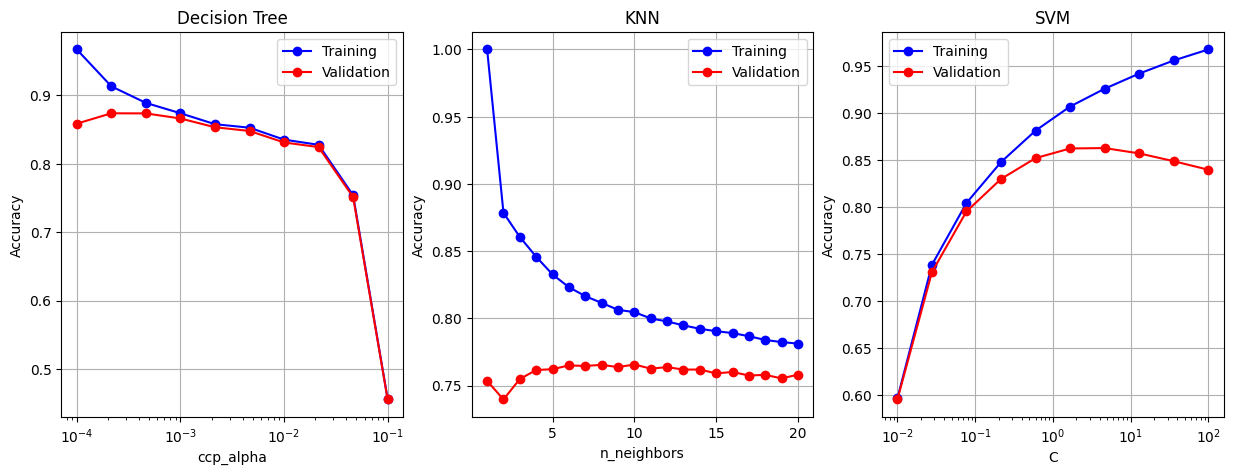

In [109]:
from sklearn.model_selection import validation_curve

def plot_validation_curves():
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    param_range = np.logspace(-4, -1, 10)
    train_scores, val_scores = validation_curve(
        DecisionTreeClassifier(ccp_alpha=0.01), x_train_scaled, y_train,
        param_name='ccp_alpha', param_range=param_range,
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    
    axes[0].semilogx(param_range, train_mean, 'o-', color='blue', label='Training')
    axes[0].semilogx(param_range, val_mean, 'o-', color='red', label='Validation')
    axes[0].set_title('Decision Tree')
    axes[0].set_xlabel('ccp_alpha')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    param_range = range(1, 21)
    train_scores, val_scores = validation_curve(
        KNeighborsClassifier(n_neighbors=8), x_train_scaled, y_train,
        param_name='n_neighbors', param_range=param_range,
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    
    axes[1].plot(param_range, train_mean, 'o-', color='blue', label='Training')
    axes[1].plot(param_range, val_mean, 'o-', color='red', label='Validation')
    axes[1].set_title('KNN')
    axes[1].set_xlabel('n_neighbors')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    param_range = np.logspace(-2, 2, 10)
    train_scores, val_scores = validation_curve(
        SVC(), x_train_scaled, y_train,
        param_name='C', param_range=param_range,
        cv=3, scoring='accuracy', n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    
    axes[2].semilogx(param_range, train_mean, 'o-', color='blue', label='Training')
    axes[2].semilogx(param_range, val_mean, 'o-', color='red', label='Validation')
    axes[2].set_title('SVM')
    axes[2].set_xlabel('C')
    axes[2].set_ylabel('Accuracy')
    axes[2].legend()
    axes[2].grid(True)
    
plot_validation_curves()

## Feature Usage

The feature usage results, as shown in the bar chart, provide insights into how different models utilize features in the dataset. Here's an analysis based on the chart and the codebase:



### **1. Decision Tree**
- **Without Feature Selection (No FS)**:
  - Uses all features in the dataset.
  - This can lead to overfitting, as the model may rely on irrelevant or redundant features.
- **With Feature Selection (FS)**:
  - Uses significantly fewer features (e.g., 3 features).
  - Feature selection improves interpretability and reduces complexity but does not necessarily improve accuracy (as noted in the metrics section).



### **2. K-Nearest Neighbors (KNN)**
- **Without Feature Selection (No FS)**:
  - Uses all features in the dataset.
  - KNN is sensitive to irrelevant features, which can degrade performance.
- **With Feature Selection (FS)**:
  - Uses fewer features (e.g., 5 features).
  - Feature selection significantly improves KNN's performance by reducing noise and focusing on the most relevant features.



### **3. Support Vector Machine (SVM)**
- **Without Feature Selection (No FS)**:
  - Uses all features in the dataset.
  - SVM performs well even without feature selection, but using all features increases computational cost.
- **With Feature Selection (FS)**:
  - Not shown in the chart, but feature selection could reduce computational cost and improve interpretability.



### **4. Neural Network**
- Uses all features in the dataset.
- Neural networks are capable of handling complex patterns and are less sensitive to irrelevant features, so feature selection is less critical for this model.



### **Key Observations**
- Feature selection significantly improves KNN's performance by reducing noise.
- For Decision Trees, feature selection reduces complexity but does not improve accuracy.
- SVM and Neural Networks perform well without feature selection, but feature selection could reduce computational cost for SVM.
- Models with feature selection (e.g., Decision Tree FS, KNN FS) use fewer features, which simplifies the model and reduces overfitting risks.
- Models without feature selection (e.g., SVM, Neural Network) rely on all features, which may increase computational cost but can handle complex patterns effectively.

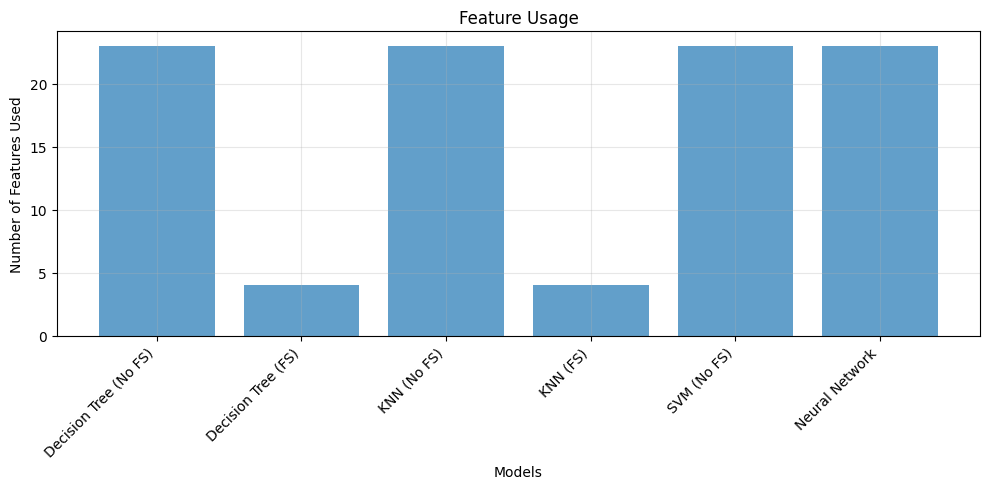

In [110]:
def plot_model_comparison():    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))

    feature_counts = []
    model_names_features = []
    for model_name, response in models.items():
        features = response.get_features()
        if len(features) > 0:
            feature_counts.append(len(features))
            model_names_features.append(model_name)
        else:
            feature_counts.append(len(x_train.columns))
            model_names_features.append(model_name)
    
    axes.bar(range(len(feature_counts)), feature_counts, alpha=0.7)
    axes.set_xlabel('Models')
    axes.set_ylabel('Number of Features Used')
    axes.set_title('Feature Usage')
    axes.set_xticks(range(len(model_names_features)))
    axes.set_xticklabels(model_names_features, rotation=45, ha='right')
    axes.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
plot_model_comparison()

## Overfitting Analysis

The overfitting analysis results, as shown in the bar chart, compare the training and test accuracies of different models to identify overfitting or underfitting. Here's an analysis based on the chart and the codebase:



### **1. Decision Tree**
- Training accuracy is slightly lower than test accuracy (gap: **-0.2%**).
- This indicates that the Decision Tree is not overfitting and generalizes well to unseen data.
- The model is well-regularized, likely due to the use of the `ccp_alpha` parameter for pruning.



### **2. K-Nearest Neighbors (KNN)**
- Training accuracy is higher than test accuracy (gap: **5.3%**).
- This suggests mild overfitting, where the model performs better on the training data than on the test data.
- KNN's sensitivity to irrelevant features may contribute to this gap. Feature selection could help reduce overfitting.



### **3. Support Vector Machine (SVM)**
- Training accuracy is slightly higher than test accuracy (gap: **3.1%**).
- This indicates good generalization with minimal overfitting.
- SVM's regularization parameter (`C`) likely helps balance the trade-off between bias and variance.



### **4. Neural Network**
- Training accuracy is slightly higher than test accuracy (gap: **3.9%**).
- This suggests good generalization with minimal overfitting.
- The use of techniques like early stopping and adaptive learning rate contributes to the model's ability to generalize well.



### **Key Observations**
- Decision Tree shows the smallest gap, indicating excellent generalization.
- SVM and Neural Network also generalize well, with small gaps between training and test accuracies.
- KNN shows mild overfitting, likely due to its reliance on all features. Feature selection could mitigate this.
- Simpler models like Decision Tree and KNN are more prone to overfitting or underfitting, depending on feature selection and hyperparameter tuning.
- More complex models like SVM and Neural Networks handle generalization better.


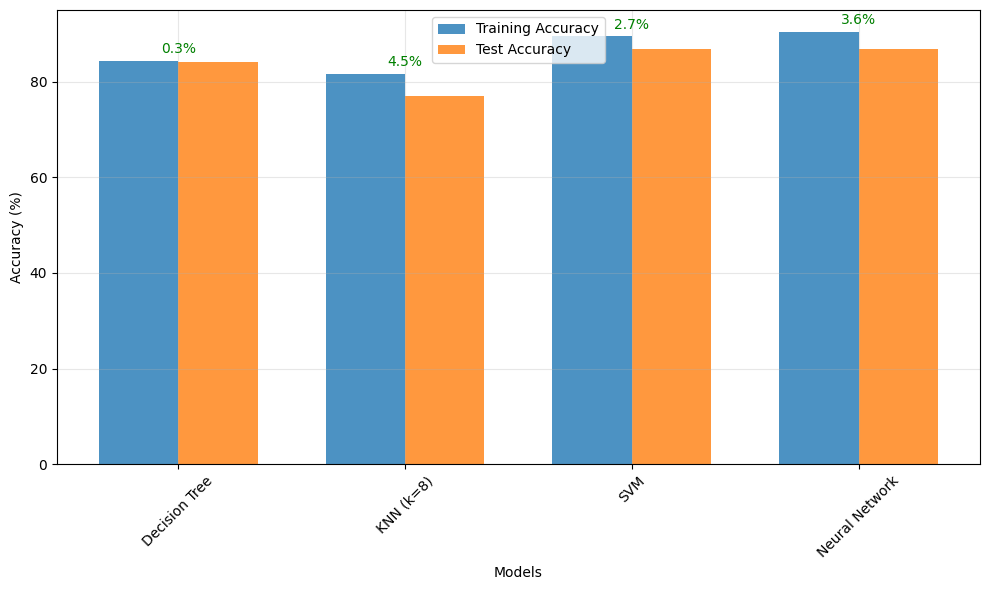

In [111]:
from sklearn.preprocessing import LabelEncoder

def analyze_model_complexity():
    complexity_models = {
        'Decision Tree': DecisionTreeClassifier(ccp_alpha=0.01),
        'KNN (k=8)': KNeighborsClassifier(n_neighbors=8),
        'SVM': SVC(probability=True),
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(250, 150, 100),
            activation='relu',
            solver='adam',                    
            alpha=0.0001,                      
            batch_size='auto',
            learning_rate='adaptive',         
            max_iter=1000,                     
            early_stopping=True,               
            validation_fraction=0.2,          
            n_iter_no_change=10,          
        )
    }
    
    train_accuracies = []
    test_accuracies = []
    model_names = []
    
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    for name, model in complexity_models.items():        
        if name == 'Neural Network':
            model.fit(x_train_scaled, y_train_encoded)
            train_acc = model.score(x_train_scaled, y_train_encoded)
            test_acc = model.score(x_test_scaled, y_test_encoded)
        else:
            model.fit(x_train_scaled, y_train)
            train_acc = model.score(x_train_scaled, y_train)
            test_acc = model.score(x_test_scaled, y_test)
        
        train_accuracies.append(train_acc * 100)
        test_accuracies.append(test_acc * 100)
        model_names.append(name)
    
    if train_accuracies and test_accuracies:
        plt.figure(figsize=(10, 6))
        
        x_pos = np.arange(len(model_names))
        width = 0.35
        
        plt.bar(x_pos - width/2, train_accuracies, width, label='Training Accuracy', alpha=0.8)
        plt.bar(x_pos + width/2, test_accuracies, width, label='Test Accuracy', alpha=0.8)
        
        plt.xlabel('Models')
        plt.ylabel('Accuracy (%)')
        plt.xticks(x_pos, model_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        for i, (train, test) in enumerate(zip(train_accuracies, test_accuracies)):
            gap = train - test
            plt.annotate(f'{gap:.1f}%', 
                xy=(i, max(train, test) + 1), 
                ha='center', va='bottom', fontsize=10,
                color='red' if gap > 10 else 'orange' if gap > 5 else 'green')
        
        plt.tight_layout()
        plt.show()
        
analyze_model_complexity()

## Conclusion

The overfitting analysis and model evaluation reveal the following key insights:
- The **Neural Network** and **SVM** demonstrate the best generalization, with small gaps between training and test accuracies. These models handle complex patterns effectively and are less prone to overfitting.
- **KNN** shows mild overfitting, as indicated by a noticeable gap between training and test accuracies. This is likely due to its sensitivity to irrelevant features. Feature selection significantly improves its performance by reducing noise.
- The **Decision Tree** avoids overfitting due to the use of the `ccp_alpha` parameter for pruning. However, it may underfit in some cases, as its performance does not improve significantly with feature selection.
- Feature selection has a significant impact on **KNN**, improving both accuracy and efficiency. For **Decision Trees**, it reduces complexity but does not enhance accuracy. **SVM** and **Neural Networks** perform well without feature selection, though feature selection could reduce computational costs for SVM.
- Simpler models like **Decision Trees** and **KNN** are more prone to overfitting or underfitting, depending on hyperparameter tuning and feature selection. More complex models like **SVM** and **Neural Networks** handle generalization better but are computationally more intensive.
- Most models struggle with distinguishing between overlapping classes like "Normal_Weight" and "Overweight_Level_I." This indicates a need for further feature engineering or advanced techniques to improve class separation.
- The **Decision Tree (No FS)** is the fastest model, while the **Neural Network** achieves a good balance between execution time and accuracy.